## Unsupervised Learning

#### Lovelina Richter, November 2020

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv ('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv ('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

(891221, 85)

In [4]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
feat_info.shape

(85, 4)

In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [9]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SEMIO_VERT,person,ordinal,[-1]
freq,1,43,49,26


In [10]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [11]:
#backup original files before processing
df_azdias = azdias.copy()
feat_infobk = feat_info.copy()
feat_infobk2 = feat_info.copy()

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

##### Identify missing or unknown data values and convert them to NaNs.

In [12]:
# Total number of missing values
display(df_azdias.isnull().sum())

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

##### Fill null values based on feat_info attribute missing_or_unknown

In [13]:
#Steps
#1. Define attribute
#2. Remove '[' and ']'
#3. Split the value into string
#4. Check if value contains 'X' or 'XX' or blank
#5. Convert the missing
for indx in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        df_azdias = df_azdias.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)

In [14]:
df_azdias.sample(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
589139,NaN,3.0,2,1.0,3,2,3,5,3,2,...,4.0,2.0,1.0,1.0,1.0,4.0,5.0,2.0,3.0,2.0
754547,NaN,1.0,2,2.0,2,4,3,5,4,3,...,3.0,3.0,1.0,0.0,1.0,3.0,3.0,3.0,6.0,5.0
269147,3.0,3.0,2,3.0,2,3,3,3,2,3,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,4.0,9.0,3.0
403579,NaN,3.0,1,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82999,NaN,3.0,2,2.0,5,2,4,4,2,1,...,3.0,3.0,2.0,0.0,1.0,3.0,3.0,3.0,4.0,2.0


In [15]:
df_azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

In [16]:
df_azdias.shape

(891221, 85)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [17]:
# Perform an assessment of how much missing data there is in each column of the dataset.
missingvalues=df_azdias.isnull().sum()
missingvalues.sort_values(ascending=True,inplace=True)
missingvalues

ZABEOTYP                      0
SEMIO_TRADV                   0
SEMIO_PFLICHT                 0
SEMIO_KAEM                    0
SEMIO_DOM                     0
SEMIO_KRIT                    0
SEMIO_RAT                     0
SEMIO_KULT                    0
SEMIO_ERL                     0
SEMIO_LUST                    0
SEMIO_VERT                    0
SEMIO_MAT                     0
SEMIO_REL                     0
SEMIO_SOZ                     0
SEMIO_FAM                     0
FINANZ_VORSORGER              0
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
FINANZTYP                     0
ALTERSKATEGORIE_GROB       2881
GFK_URLAUBERTYP            4854
LP_STATUS_GROB             4854
LP_STATUS_FEIN             4854
ONLINE_AFFINITAET          4854
RETOURTYP_BK_S             4854
                          ...  
CAMEO_IN

In [18]:
#missingvalues = (missingvalues/len(df_azdias))*100
missingvalues=missingvalues[missingvalues>0]/(df_azdias.shape[0])*100 

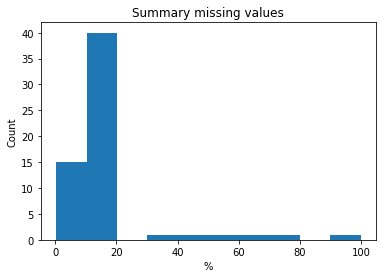

In [19]:
#compute missing values and display in histogram
plt.hist(missingvalues)
plt.xlabel('%')
plt.ylabel('Count')
plt.title('Summary missing values')
plt.show()

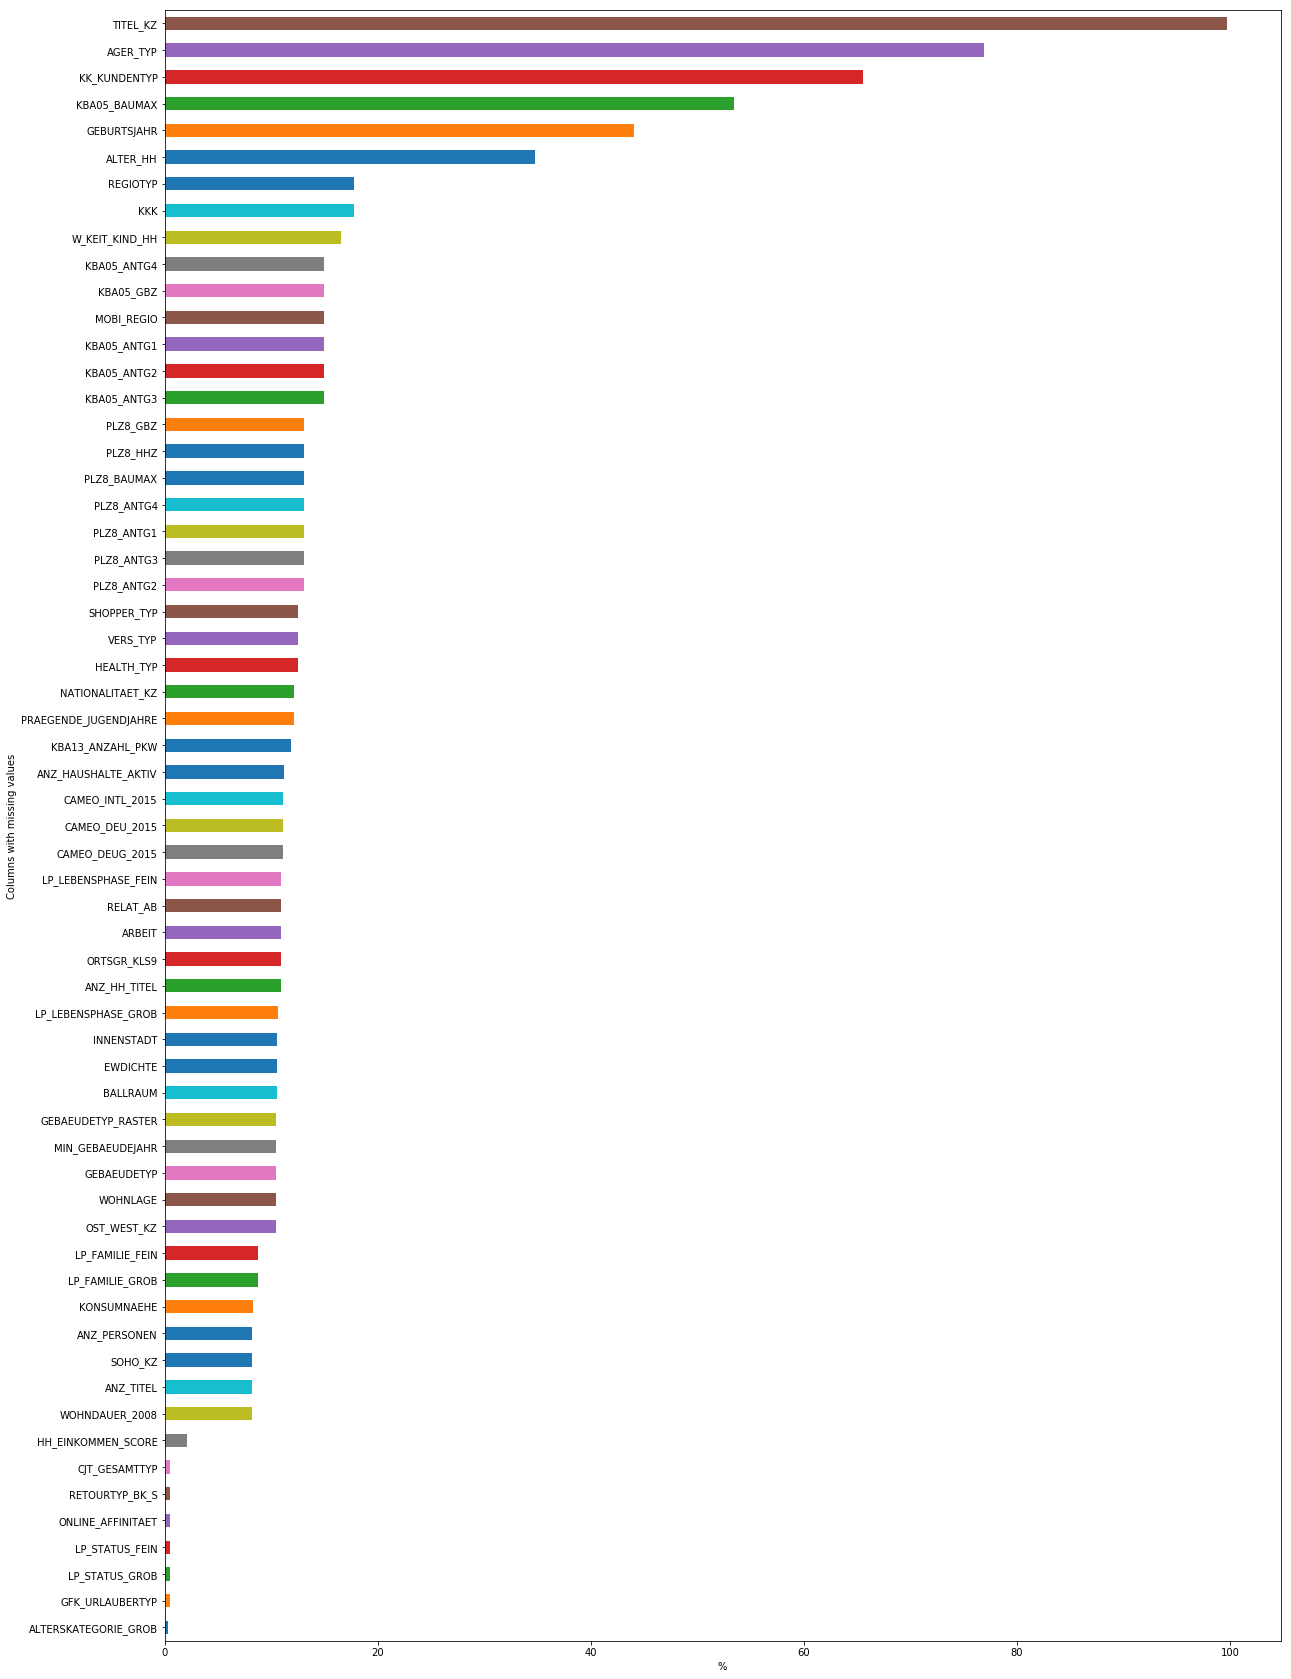

In [20]:
# Investigate patterns in the amount of missing data in each column.
missingvalues.plot.barh(figsize=(20,30))
plt.xlabel('%')
plt.ylabel('Columns with missing values')
plt.show()

In [21]:
 #Identify outliers
missingvalues[missingvalues>30].index  

Index(['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP',
       'TITEL_KZ'],
      dtype='object')

In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
columns=missingvalues[missingvalues>30].index

In [23]:
columns

Index(['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP',
       'TITEL_KZ'],
      dtype='object')

In [24]:
#Check one of the columns
df_azdias.ALTER_HH.value_counts()

18.0    60852
17.0    55665
19.0    52890
15.0    51867
16.0    51857
14.0    44275
21.0    41610
20.0    40671
13.0    37612
12.0    34923
10.0    30419
11.0    27924
9.0     22817
8.0     13463
7.0      8419
6.0      3809
5.0      1030
4.0       603
3.0       200
2.0        47
1.0         1
Name: ALTER_HH, dtype: int64

In [25]:
df_azdias.drop(columns=columns,axis="columns",inplace=True)

In [26]:
#Check if  the 6 outliers were dropped
df_azdias.shape

(891221, 79)

In [27]:
df_azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

After replacing the missing_or_unknown values with numpy NaN, there are 6 columns which have 30% missing values. The rest of the columns have less than 30% missing values. Below are the outliers deleted from the dataset and will be exclued from analysis.

TITEL_KZ                 99.757636

AGER_TYP                 76.955435

KK_KUNDENTYP             65.596749

KBA05_BAUMAX             53.468668

GEBURTSJAHR              44.020282

ALTER_HH                 34.813699

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [28]:
# How much data is missing in each row of the dataset?
missingval_rows=df_azdias.isnull().sum(axis=1)

In [29]:
missingval_rows.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

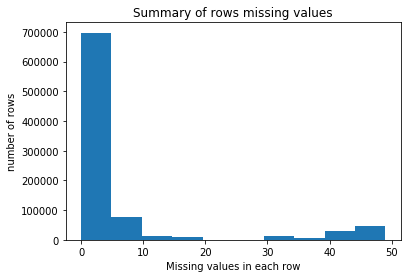

In [30]:
#Visualize missing row values
plt.hist(missingval_rows)
plt.xlabel('Missing values in each row')
plt.ylabel('number of rows')
plt.title('Summary of rows missing values')
plt.show()

In [31]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
subset1_less30 = df_azdias[missingval_rows<30]
#subset1_less30

In [32]:
subset2_more30 = df_azdias[missingval_rows>=30]
#subset2_more30

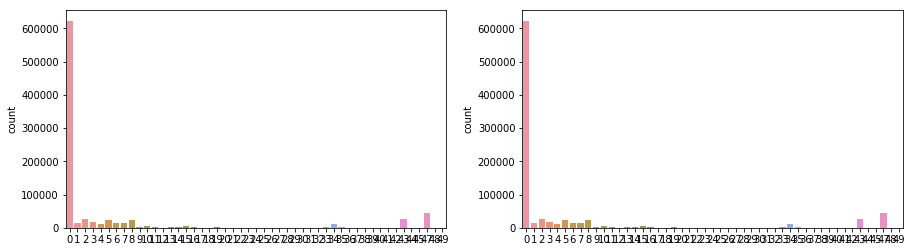

In [33]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
sns.countplot(x=missingval_rows, data=subset1_less30, ax=ax1)
sns.countplot(x=missingval_rows, data=subset2_more30, ax=ax2)
plt.show()

In [34]:
columns=missingvalues[missingvalues<30].index

In [35]:
top_5_missing=columns[:5]

In [36]:
top_5_missing

Index(['ALTERSKATEGORIE_GROB', 'GFK_URLAUBERTYP', 'LP_STATUS_GROB',
       'LP_STATUS_FEIN', 'ONLINE_AFFINITAET'],
      dtype='object')

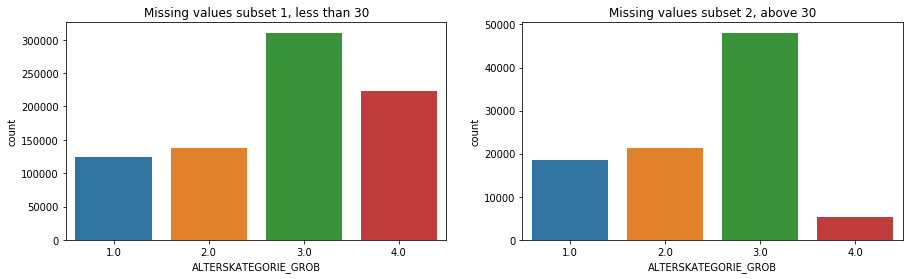

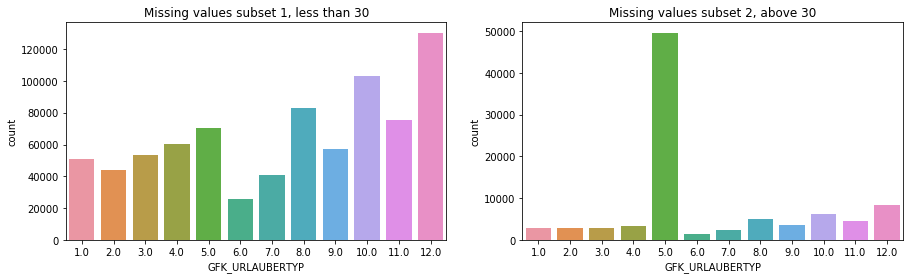

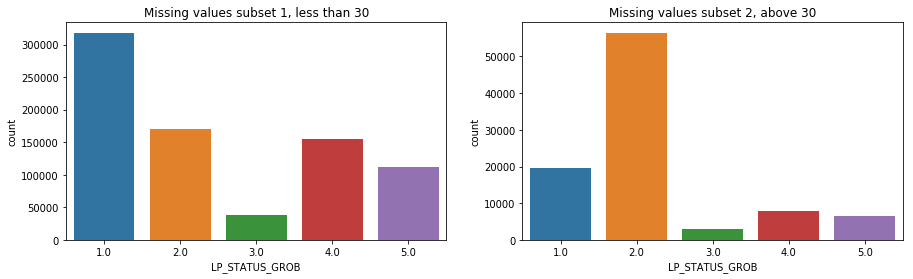

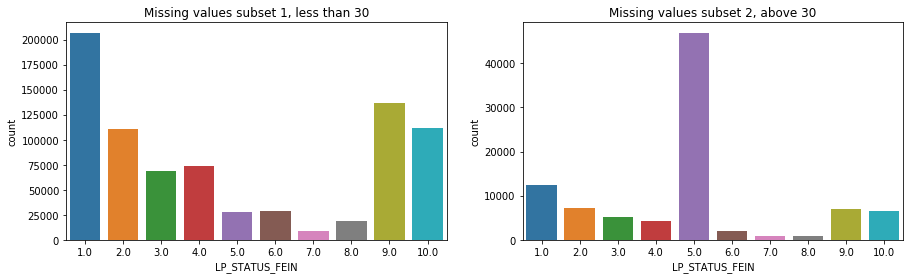

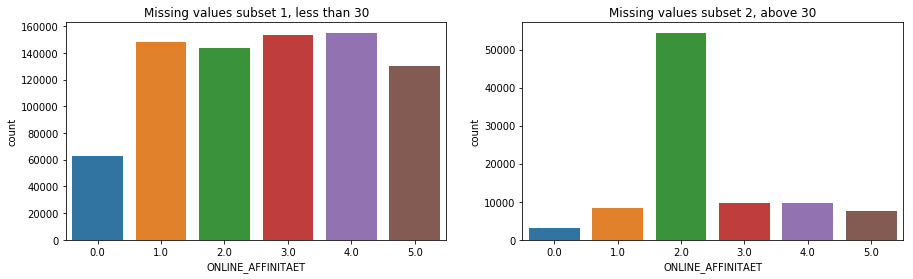

In [37]:
for i in range(top_5_missing.size):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.set_title('Missing values subset 1, less than 30')
    sns.countplot(df_azdias.loc[subset1_less30.index,top_5_missing[i]],ax=ax1)

    ax2.set_title('Missing values subset 2, above 30')
    sns.countplot(df_azdias.loc[subset2_more30.index,top_5_missing[i]],ax=ax2)
    
    plt.show()

In [38]:
#fill missing values
subset1_less30=subset1_less30.fillna(subset1_less30.mode().iloc[0])

In [39]:
subset1_less30.isnull().sum(axis=1)

1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
12        0
13        0
15        0
16        0
18        0
19        0
20        0
21        0
22        0
23        0
25        0
26        0
27        0
28        0
29        0
31        0
32        0
33        0
34        0
36        0
         ..
891191    0
891192    0
891193    0
891194    0
891195    0
891196    0
891197    0
891198    0
891199    0
891200    0
891201    0
891202    0
891203    0
891204    0
891205    0
891206    0
891207    0
891208    0
891209    0
891210    0
891211    0
891212    0
891213    0
891214    0
891215    0
891216    0
891217    0
891218    0
891219    0
891220    0
Length: 798061, dtype: int64

#### Discussion 1.1.3: Assess Missing Data in Each Row

The data was checked for missing data in rows. There are 623,209 with zero missing values. The rows with missing data were divided into two subsets. Based on the histogram chartabove, the split can divided by threshold of 30. Subset 1 is less than 30 and subset 2 is more than and equal 30. The subset 2 is a smaller group compared to subset 1. The subset 1 has 798,061 rows and subset 2 has 93,160 rows. The missing values were filled.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [40]:
# How many features are there of each data type?
feat_info=feat_info[feat_info.attribute.isin(subset1_less30.columns)]
feat_info.type.value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [41]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_info[feat_info.type=="categorical"]

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [42]:
categ_var=feat_info[feat_info.type=="categorical"]

In [43]:
binary_level=[]
multi_level=[]

for col in categ_var.attribute:
    if subset1_less30[col].nunique()==2:
        binary_level.append(col)
    else:
        multi_level.append(col)

In [44]:
print('Binary level: {}'.format(binary_level))
print('Multi-level: {}'.format(multi_level))

Binary level: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi-level: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [45]:
for col in binary_level:
    print(subset1_less30[col].value_counts())

2    416177
1    381884
Name: ANREDE_KZ, dtype: int64
0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791344
1.0      6717
Name: SOHO_KZ, dtype: int64
2.0    430959
1.0    367102
Name: VERS_TYP, dtype: int64
W    629520
O    168541
Name: OST_WEST_KZ, dtype: int64


In [46]:
# Re-encode categorical variable(s) to be kept in the analysis.
subset1_less30["ANREDE_KZ"].replace({2:0,1:1},inplace=True)
subset1_less30["SOHO_KZ"].replace({0.0:0,1.0:1},inplace=True)
subset1_less30["VERS_TYP"].replace({2:0,1:1},inplace=True)
subset1_less30["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)
subset1_less30["OST_WEST_KZ"].astype('int',inplace=True)
subset1_less30=pd.get_dummies(data=subset1_less30,columns=multi_level)


In [47]:
#Check Changes
for col in binary_level:
    print(subset1_less30[col].value_counts())

0    416177
1    381884
Name: ANREDE_KZ, dtype: int64
0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791344
1.0      6717
Name: SOHO_KZ, dtype: int64
0.0    430959
1.0    367102
Name: VERS_TYP, dtype: int64
0    629520
1    168541
Name: OST_WEST_KZ, dtype: int64


In [48]:
subset1_less30.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798061 entries, 1 to 891220
Columns: 194 entries, ALTERSKATEGORIE_GROB to CAMEO_DEU_2015_9E
dtypes: float64(42), int64(23), object(1), uint8(128)
memory usage: 505.4+ MB


In [49]:
subset1_less30.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,0,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,0,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,0,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,0,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,0,0,0,0


In [50]:
subset1_less30.shape

(798061, 194)

#### Discussion 1.2.1: Re-Encode Categorical Features

There are 18 'categorical' in dataset. The categorical attributes were checked if they are binary (two-level) or multi-level (more than 2). The binary levels such as 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ', were inspected if the values need to be reencoded. The column OST_WEST_KZ with value 'W' and 'O' were replaced with 0 and 1 respectively. Similarly, 'ANREDE_KZ' and 'VERS_TYP' values of 2 and 1 are replaced with 0 and 1. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [51]:
#Check two features described above
feat_info[feat_info.type=="mixed"]

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [52]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
subset1_less30['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    211738
8.0     141630
10.0     85808
5.0      84691
3.0      53845
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

##### Data_dictonary.md 
1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [53]:
#define dictionary of decade and movement (avantgarde vs. mainstream)
#1=40s, 2=50s, 3=60s, 4=70s, 5=80s, 6=90s
decade_dictionary={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}

#1=Mainstream, 0=Avantgarde
movement_dictionary={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}

In [54]:
#Add two new variables to dataset
subset1_less30["DECADE"]=subset1_less30.PRAEGENDE_JUGENDJAHRE
subset1_less30["MOVEMENT"]=subset1_less30.PRAEGENDE_JUGENDJAHRE

In [55]:
#replace value based on defined values in dictionary
subset1_less30["DECADE"].replace(decade_dictionary,inplace=True)
subset1_less30["MOVEMENT"].replace(movement_dictionary,inplace=True)

In [56]:
#drop the old/original variable
subset1_less30.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)

In [57]:
#check new values
subset1_less30['DECADE'].value_counts()

6.0    254285
4.0    175200
5.0    151770
3.0    114353
2.0     74296
1.0     28157
Name: DECADE, dtype: int64

In [58]:
#check new values
subset1_less30['MOVEMENT'].value_counts()

1.0    622836
0.0    175225
Name: MOVEMENT, dtype: int64

In [59]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
subset1_less30['CAMEO_INTL_2015'].value_counts()

51    139892
41     92336
24     91157
14     62884
43     56672
54     45391
25     39626
22     33154
23     26750
13     26335
45     26132
55     23955
52     20542
31     19023
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

##### Data_dictionary.md
4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [60]:
#define data dictionary of wealth and lifestage
#1=Wealthy
#2=Prosperous
#3=Comfortable
#4=Less Affluent Households
#5=Poorer Households
wealth_dictionary={'11':1,'12':1,'13':1,'14':1,'15':1,
            '21':2,'22':2,'23':2,'24':2,'25':2,
            '31':3,'32':3,'33':3,'34':3,'35':3,
            '41':4,'42':4,'43':4,'44':4,'45':4,
            '51':5,'52':5,'53':5,'54':5,'55':5
            }

#1=Pre-Family Couples & Singles
#2=Young Couples With Children
#3=Families With School Age Children
#4=Older Families & Mature Couples
#5=Elders In Retirement
lifestage_dictionary={'11':1,'12':2,'13':3,'14':4,'15':5,
            '21':1,'22':2,'23':3,'24':4,'25':5,
            '31':1,'32':2,'33':4,'34':4,'35':5,
            '41':1,'42':2,'43':3,'44':4,'45':5,
            '51':1,'52':2,'53':3,'54':4,'55':5
            }

In [61]:
#Add two new variables to dataset
subset1_less30["WEALTH"]=subset1_less30.CAMEO_INTL_2015
subset1_less30["LIFE_STAGE"]=subset1_less30.CAMEO_INTL_2015

In [62]:
#replace value based on defined values in dictionary
subset1_less30["WEALTH"].replace(wealth_dictionary,inplace=True)
subset1_less30["LIFE_STAGE"].replace(lifestage_dictionary,inplace=True)

In [63]:
#drop the old/original variable
subset1_less30.drop("CAMEO_INTL_2015",axis=1,inplace=True)

In [64]:
#check new values
subset1_less30['WEALTH'].value_counts()

5    229780
2    190687
4    189960
1    119442
3     68192
Name: WEALTH, dtype: int64

In [65]:
#check new values
subset1_less30['LIFE_STAGE'].value_counts()

1    251251
4    242711
5    117043
3    109757
2     77299
Name: LIFE_STAGE, dtype: int64

In [66]:
subset1_less30.shape

(798061, 196)

#### Discussion 1.2.2: Engineer Mixed-Type Features

For this step, Engineer mixed-type features, I focused on the two variables PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 indicated in the guide. 

##### Created two new variables for PRAEGENDE_JUGENDJAHRE based on decade and movement, new values are mapped as follows:

Decade: 1=40s, 2=50s, 3=60s, 4=70s, 5=80s, 6=90s

Movement: 1=Mainstream, 0=Avantgarde

##### Created two new varaibles for CAMEO based on Wealth amd Life Stage, new values are mapped as follows:

Wealth: 1=Wealthy, 2=Prosperous, 3=Comfortable,4=Less Affluent Households, 5=Poorer Households

Life Stage: 1=Pre-Family Couples & Singles, 2=Young Couples With Children, 3=Families With School Age Children, 4=Older Families & Mature Couples, 5=Elders In Retirement

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [67]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#Check type in dataset
feat_info=feat_info[feat_info.attribute.isin(subset1_less30.columns)]
feat_info.type.value_counts()

ordinal        49
numeric         6
categorical     5
mixed           4
Name: type, dtype: int64

In [68]:
#check the remaining 4 mixed-type features
feat_info[feat_info.type=="mixed"]

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
56,WOHNLAGE,building,mixed,[-1]
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


Upon checking the following mixed-typed features doesn't require to be engineered or not needed for analysis.

LP_LEBENSPHASE_FEIN - #Life stage, fine scale

LP_LEBENSPHASE_GROB - Life stage, rough scale

WOHNLAGE - Neighborhood quality (or rural flag)

PLZ8_BAUMAX - Most common building type within the PLZ8 region

In [69]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

mixed_type=feat_info[feat_info.type=="mixed"]
for mixed_type in mixed_type["attribute"]:
    if mixed_type in subset1_less30.columns:
        subset1_less30.drop(mixed_type,axis=1,inplace=True)

In [70]:
subset1_less30.shape

(798061, 192)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [71]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    #Step 1.1.1
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for indx in range(len(feat_info)):
        missingorunknown = feat_info.iloc[indx]['missing_or_unknown']
        missingorunknown = missingorunknown.strip('[')
        missingorunknown = missingorunknown.strip(']')
        missingorunknown = missingorunknown.split(sep=',')
        missingorunknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missingorunknown]
        if missingorunknown != ['']:
            df = df.replace({feat_info.iloc[indx]['attribute']: missingorunknown}, np.nan)
    
    print(df.shape)
    
    #Step 1.1.2
    # remove selected columns and rows, ...
    missingvalues_cd=df.isnull().sum()
    missingvalues_cd.sort_values(ascending=True,inplace=True)
    missingvalues_cd=missingvalues_cd[missingvalues_cd>0]/(df.shape[0])*100     

    #Remove outlier
    columns=missingvalues_cd[missingvalues_cd>30].index
    df.drop(columns=columns,axis="columns",inplace=True)
    print(df.shape)
    
    #Step 1.1.3
    missingvalrows=df.isnull().sum(axis=1)
    
    subset_less30 = df[missingvalrows<30]
    subset_more30 = df[missingvalrows>=30]
    
    columns=missingvalues_cd[missingvalues_cd<30].index
    
    subset_less30=subset_less30.fillna(subset_less30.mode().iloc[0])
    
    #Step 1.2.1
    # select, re-encode, and engineer column values.
    feat_info=feat_info[feat_info.attribute.isin(subset_less30.columns)]
    categvar=feat_info[feat_info.type=="categorical"]
    
    print(categvar) #to debug what fields are categorical
    
    binarylevel=[]
    multilevel=[]

    for col1 in categvar.attribute:
        if subset_less30[col1].nunique()==2:
            binarylevel.append(col1)
        else:
            multilevel.append(col1)
    
    print('Binary level: {}'.format(binarylevel)) #to debug binary fields
    print('Multi-level: {}'.format(multilevel)) #to debug multi-level fields
    
    subset_less30["ANREDE_KZ"].replace({2:0,1:1},inplace=True)
    subset_less30["SOHO_KZ"].replace({0.0:0,1.0:1},inplace=True)
    subset_less30["VERS_TYP"].replace({2:0,1:1},inplace=True)
    subset_less30["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)
    subset_less30["OST_WEST_KZ"].astype('int',inplace=True)
    subset_less30=pd.get_dummies(data=subset_less30,columns=multilevel)
    
    print(subset_less30.shape)
    
    #Step1.2.2
    decade_dictionary={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    movement_dictionary={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
   
    subset_less30["DECADE"]=subset_less30.PRAEGENDE_JUGENDJAHRE
    subset_less30["MOVEMENT"]=subset_less30.PRAEGENDE_JUGENDJAHRE
    
    subset_less30["DECADE"].replace(decade_dictionary,inplace=True)
    subset_less30["MOVEMENT"].replace(movement_dictionary,inplace=True)
    
    subset_less30.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)
    
    wealth_dictionary={'11':1,'12':1,'13':1,'14':1,'15':1,
            '21':2,'22':2,'23':2,'24':2,'25':2,
            '31':3,'32':3,'33':3,'34':3,'35':3,
            '41':4,'42':4,'43':4,'44':4,'45':4,
            '51':5,'52':5,'53':5,'54':5,'55':5
            }

    lifestage_dictionary={'11':1,'12':2,'13':3,'14':4,'15':5,
            '21':1,'22':2,'23':3,'24':4,'25':5,
            '31':1,'32':2,'33':4,'34':4,'35':5,
            '41':1,'42':2,'43':3,'44':4,'45':5,
            '51':1,'52':2,'53':3,'54':4,'55':5
            }
    
    subset_less30["WEALTH"]=subset_less30.CAMEO_INTL_2015
    subset_less30["LIFE_STAGE"]=subset_less30.CAMEO_INTL_2015
    
    subset_less30["WEALTH"].replace(wealth_dictionary,inplace=True)
    subset_less30["LIFE_STAGE"].replace(lifestage_dictionary,inplace=True)
    
    subset_less30.drop("CAMEO_INTL_2015",axis=1,inplace=True)
    
    print(subset_less30.shape)

    #Step 1.2.3
    feat_info=feat_info[feat_info.attribute.isin(subset_less30.columns)]
    
    mixedtype=feat_info[feat_info.type=="mixed"]
    
    for mixedtype in mixedtype["attribute"]:
        if mixedtype in subset_less30.columns:
            subset_less30.drop(mixedtype,axis=1,inplace=True)

    print(subset_less30.shape)
            
    # Return the cleaned dataframe.
    return subset_less30


In [72]:
test_data = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=';')
test_cleanfunction = clean_data(test_data,feat_infobk)

(891221, 85)
(891221, 79)
           attribute information_level         type missing_or_unknown
2          ANREDE_KZ            person  categorical             [-1,0]
3      CJT_GESAMTTYP            person  categorical                [0]
10         FINANZTYP            person  categorical               [-1]
12   GFK_URLAUBERTYP            person  categorical                 []
13  GREEN_AVANTGARDE            person  categorical                 []
17   LP_FAMILIE_FEIN            person  categorical                [0]
18   LP_FAMILIE_GROB            person  categorical                [0]
19    LP_STATUS_FEIN            person  categorical                [0]
20    LP_STATUS_GROB            person  categorical                [0]
21  NATIONALITAET_KZ            person  categorical             [-1,0]
38       SHOPPER_TYP            person  categorical               [-1]
39           SOHO_KZ            person  categorical               [-1]
41          VERS_TYP            person  categorical

In [73]:
#test clean_data function
test_cleanfunction.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,0,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,6.0,1.0,5,1
2,3.0,0,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,6.0,0.0,2,4
3,4.0,0,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,4.0,1.0,1,2
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,4.0,1.0,4,3
5,1.0,0,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,2.0,1.0,5,4


In [74]:
#test clean_data function
test_cleanfunction.shape

(798061, 192)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [75]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
#check if there missing values
subset1_less30.isnull().sum().sum()

0

In [76]:
#View dataset information, values, and columns
subset1_less30.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798061 entries, 1 to 891220
Columns: 192 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE
dtypes: float64(39), int64(25), uint8(128)
memory usage: 493.2 MB


In [77]:
subset1_less30

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,0,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,6.0,1.0,5,1
2,3.0,0,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,6.0,0.0,2,4
3,4.0,0,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,4.0,1.0,1,2
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,4.0,1.0,4,3
5,1.0,0,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,2.0,1.0,5,4
6,2.0,0,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0,5.0,1.0,2,2
7,1.0,1,3,3,4,1,3,2,0,1.0,...,0,0,0,0,0,0,4.0,1.0,1,4
8,3.0,1,4,4,2,4,2,2,1,3.0,...,0,0,0,0,0,0,5.0,0.0,1,3
9,3.0,0,2,4,2,3,5,4,1,2.0,...,0,0,0,0,0,0,6.0,0.0,1,5
10,3.0,0,2,2,5,3,1,5,0,2.0,...,0,0,0,0,1,0,2.0,1.0,5,1


In [78]:
print(len(subset1_less30.columns))
for col in subset1_less30.columns:
    print(col)

192
ALTERSKATEGORIE_GROB
ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
GREEN_AVANTGARDE
HEALTH_TYP
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
SOHO_KZ
VERS_TYP
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
KONSUMNAEHE
MIN_GEBAEUDEJAHR
OST_WEST_KZ
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB
CJT_GESAMTTYP_1.0
CJT_GESAMTTYP_2.0
CJT_GESAMTTYP_3.0
CJT_GESAMTTYP_4.0
CJT_GESAMTTYP_5.0
CJT_GESAMTTYP_6.0
FINANZTYP_1
FINANZTYP_2
FINANZTYP_3
FINANZTYP_4
FINANZTYP_5
FINANZTYP_6
GFK_URLAUBERTYP_1.0
GFK_URLAUBERTYP_2.0
GFK_URLAUBERTYP_3.0
GFK_URLAUB

In [79]:
# Apply feature scaling to the general population demographics data.
#Use StandardScaler as suggested above
scaler=StandardScaler()
features_scaled=scaler.fit_transform(subset1_less30)

In [80]:
features_scaled=pd.DataFrame(features_scaled,columns=subset1_less30.columns.tolist())

In [81]:
features_scaled

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.766646,-0.957914,-1.494594,1.537924,-1.040692,1.465965,0.958645,1.339314,-0.530409,1.010164,...,-0.150064,-0.162542,-0.189539,-0.179782,-0.192768,-0.089764,1.098070,0.530409,1.175657,-1.252793
1,0.200522,-0.957914,-1.494594,0.864563,-1.766980,-0.570998,0.244119,1.339314,1.885336,1.010164,...,-0.150064,-0.162542,-0.189539,-0.179782,-0.192768,-0.089764,1.098070,-1.885336,-0.869680,0.756034
2,1.184106,-0.957914,0.683144,-0.482158,1.138172,-0.570998,-1.184933,-0.791205,-0.530409,-0.311816,...,-0.150064,-0.162542,-0.189539,-0.179782,-0.192768,-0.089764,-0.267778,0.530409,-1.551459,-0.583184
3,0.200522,1.043935,0.683144,0.191203,0.411884,-1.249985,0.244119,-0.791205,-0.530409,1.010164,...,-0.150064,-0.162542,-0.189539,-0.179782,-0.192768,-0.089764,-0.267778,0.530409,0.493878,0.086425
4,-1.766646,-0.957914,-0.042768,-1.155518,1.138172,-0.570998,-0.470407,1.339314,-0.530409,1.010164,...,-0.150064,-0.162542,-0.189539,-0.179782,-0.192768,-0.089764,-1.633627,0.530409,1.175657,0.756034
5,-0.783062,-0.957914,-1.494594,1.537924,-1.766980,1.465965,0.958645,-0.081032,-0.530409,-0.311816,...,-0.150064,-0.162542,-0.189539,-0.179782,-0.192768,-0.089764,0.415146,0.530409,-0.869680,-0.583184
6,-1.766646,1.043935,-0.042768,0.191203,0.411884,-1.249985,0.244119,-0.791205,-0.530409,-1.633796,...,-0.150064,-0.162542,-0.189539,-0.179782,-0.192768,-0.089764,-0.267778,0.530409,-1.551459,0.756034
7,0.200522,1.043935,0.683144,0.864563,-1.040692,0.786978,-0.470407,-0.791205,1.885336,1.010164,...,-0.150064,-0.162542,-0.189539,-0.179782,-0.192768,-0.089764,0.415146,-1.885336,-1.551459,0.086425
8,0.200522,-0.957914,-0.768681,0.864563,-1.040692,0.107990,1.673172,0.629141,1.885336,-0.311816,...,-0.150064,-0.162542,-0.189539,-0.179782,-0.192768,-0.089764,1.098070,-1.885336,-1.551459,1.425643
9,0.200522,-0.957914,-0.768681,-0.482158,1.138172,0.107990,-1.184933,1.339314,-0.530409,-0.311816,...,-0.150064,-0.162542,-0.189539,-0.179782,5.187587,-0.089764,-1.633627,0.530409,1.175657,-1.252793


### Discussion 2.1: Apply Feature Scaling

Before applying feature scaling, the dataset was investigated if there are remaining missing data. As a result of data cleanup processes above, there are no missing values, therefore I applied feature scaling by using StandardScaler function as suggested in the instruction.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [82]:
# Apply PCA to the data.
pca = PCA()
pca.fit(features_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

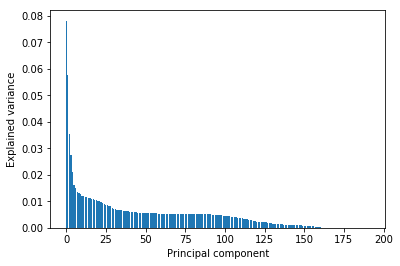

In [83]:
# Investigate the variance accounted for by each principal component.
number_components=np.arange(len(pca.explained_variance_ratio_))
values=pca.explained_variance_ratio_
plt.bar(number_components,values)
plt.xlabel("Principal component")
plt.ylabel("Explained variance")
plt.show()

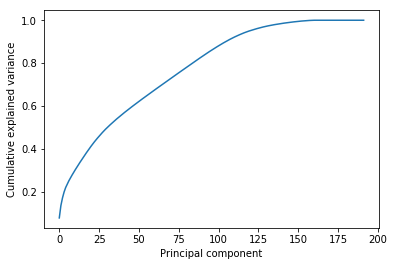

In [84]:
cummulative_values = np.cumsum(values)
plt.plot(number_components,cummulative_values)
plt.xlabel("Principal component")
plt.ylabel("Cumulative explained variance")
plt.show()

In [85]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_80 = PCA(n_components=80)
data_PCA = pca_80.fit_transform(features_scaled)
data_PCA

array([[ 4.94307509, -3.74301425, -3.14715095, ..., -0.20052937,
        -0.3123712 ,  2.92131819],
       [-0.46096208, -0.59177311, -3.29054548, ...,  0.39553672,
         0.30153537, -0.7363683 ],
       [-4.41710015,  1.90483305, -1.30280169, ..., -0.39789324,
        -0.36314998, -0.26098821],
       ..., 
       [-0.36776149, -3.56752122, -3.30067926, ..., -0.46653939,
         0.08040312, -0.27205259],
       [ 6.31015005, -4.34186785,  2.76070904, ..., -1.58433506,
         0.88553858,  0.53890945],
       [ 0.58142995,  2.6346874 ,  2.15179914, ...,  0.15676161,
        -0.17868188,  0.10477077]])

### Discussion 2.2: Perform Dimensionality Reduction

After performing sklearn's PCA class, the graph shown that I  need 80 components to get at least 80% or to get close to 100% variance. Therefore,I will use 80 components to retain for analysis of relationships among remaining features. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [86]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the other cells.
def PCA_weights(df,pca,n):
    weights_df=pd.DataFrame(pca.components_,columns=list(df.columns)).iloc[n]
    weights_df.sort_values(ascending=False, inplace=True)
    return weights_df

In [87]:
#Apply to the transformed principal components
PCA_weights(features_scaled,pca_80,0)

LP_STATUS_GROB_1.0      0.196908
HH_EINKOMMEN_SCORE      0.186604
WEALTH                  0.185327
PLZ8_ANTG3              0.181650
PLZ8_ANTG4              0.175215
ORTSGR_KLS9             0.154754
EWDICHTE                0.153172
FINANZ_HAUSBAUER        0.148559
KBA05_ANTG4             0.129668
LP_STATUS_FEIN_1.0      0.126063
PLZ8_ANTG2              0.125085
FINANZ_SPARER           0.119705
LP_STATUS_FEIN_2.0      0.118408
KBA05_ANTG3             0.117833
FINANZTYP_1             0.116642
ANZ_HAUSHALTE_AKTIV     0.116475
CAMEO_DEUG_2015_9       0.114812
ARBEIT                  0.113632
RELAT_AB                0.107610
MOVEMENT                0.106330
LP_FAMILIE_FEIN_1.0     0.090842
LP_FAMILIE_GROB_1.0     0.090842
CAMEO_DEUG_2015_8       0.090298
SEMIO_PFLICHT           0.087506
SEMIO_REL               0.083061
DECADE                  0.082258
ZABEOTYP_5              0.078616
SEMIO_RAT               0.072872
GEBAEUDETYP_3.0         0.067928
CAMEO_DEU_2015_8A       0.063991
          

In [88]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
PCA_weights(features_scaled,pca_80,1)

ALTERSKATEGORIE_GROB     0.231589
FINANZ_VORSORGER         0.217408
ZABEOTYP_3               0.200454
SEMIO_ERL                0.180018
SEMIO_LUST               0.162608
RETOURTYP_BK_S           0.155130
W_KEIT_KIND_HH           0.124765
CJT_GESAMTTYP_2.0        0.107948
LP_STATUS_FEIN_1.0       0.099552
FINANZTYP_5              0.098209
FINANZ_HAUSBAUER         0.090543
FINANZTYP_2              0.090229
FINANZ_MINIMALIST        0.083259
SHOPPER_TYP_3.0          0.073932
SEMIO_KRIT               0.073843
CJT_GESAMTTYP_1.0        0.070550
LP_FAMILIE_FEIN_1.0      0.069912
LP_FAMILIE_GROB_1.0      0.069912
PLZ8_ANTG3               0.068353
EWDICHTE                 0.067480
FINANZTYP_6              0.067368
PLZ8_ANTG4               0.066791
ORTSGR_KLS9              0.066348
NATIONALITAET_KZ_1.0     0.065638
WEALTH                   0.062753
SEMIO_KAEM               0.059381
GFK_URLAUBERTYP_4.0      0.059324
KBA05_ANTG4              0.054977
WOHNDAUER_2008           0.053068
ARBEIT        

In [89]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
PCA_weights(features_scaled,pca_80,2)

ANREDE_KZ                0.344989
SEMIO_VERT               0.318738
SEMIO_FAM                0.260571
SEMIO_SOZ                0.256856
SEMIO_KULT               0.251475
FINANZTYP_5              0.135896
FINANZ_MINIMALIST        0.128912
SHOPPER_TYP_0.0          0.123495
ZABEOTYP_1               0.116476
SEMIO_REL                0.113372
SEMIO_MAT                0.088834
RETOURTYP_BK_S           0.075769
GREEN_AVANTGARDE         0.074855
ORTSGR_KLS9              0.063609
EWDICHTE                 0.063578
W_KEIT_KIND_HH           0.062658
LP_STATUS_GROB_5.0       0.052467
LP_STATUS_FEIN_10.0      0.052467
ZABEOTYP_6               0.050097
PLZ8_ANTG4               0.049045
PLZ8_ANTG3               0.048809
FINANZ_VORSORGER         0.047938
LP_STATUS_FEIN_3.0       0.045203
LP_STATUS_FEIN_1.0       0.043794
PLZ8_ANTG2               0.035922
RELAT_AB                 0.035417
SHOPPER_TYP_1.0          0.035252
ARBEIT                   0.033765
LP_STATUS_GROB_3.0       0.032208
NATIONALITAET_

### Discussion 2.3: Interpret Principal Components

The result of applying weight to the principal components is quite interesting.The feature relationship from the first three principal components, can be summarized by two dominant groups, personal level such as social status, personality, gender and generation. The other group is household level, such as household income, financial topology, and region. 

For each principal component, i took the top five positive features and bottome five negative features. 

The first component has positive correlation to social status, wealth, income, and houshold region, while houses in microcell, movement pattern, and financial topology have negative correlation. Below are the scores and corresponding description from data dictionary. 

##### Positive Correlation 
LP_STATUS_GROB_1.0      0.196908 - Social Status,  rough scale

HH_EINKOMMEN_SCORE      0.186604 - Estimated household income

WEALTH                  0.185327 - Wealth

PLZ8_ANTG3              0.181650 - Number of 6-10 family houses in the PLZ8 region

PLZ8_ANTG4              0.175215 - Number of 10+ family houses in the PLZ8 region

##### Negative Correlation
KBA05_ANTG1            -0.181135 - Number of 1-2 family houses in the microcell

KBA05_GBZ              -0.181565 - Number of buildings in the microcell

PLZ8_ANTG1             -0.182944 - Number of 1-2 family houses in the PLZ8 region

MOBI_REGIO             -0.188534 - Movement patterns

FINANZ_MINIMALIST      -0.194560 - Financial typology, for each dimension

The second component has positive correlation to age, financial topology, household energy consumption, and personality. However, it is interesting that personality and financial topology have negative correlation, which also show in the possitive features. Additionally, generation seem to have a lowest negative correlation. Below are the scores and corresponding description from data dictionary. 

##### Positive Correlation 
ALTERSKATEGORIE_GROB     0.231589 - Estimated age based on given name analysis

FINANZ_VORSORGER         0.217408 - Financial typology, for each dimension

ZABEOTYP_3               0.200453 - Energy consumption typology

SEMIO_ERL                0.180018 - Personality typology, for each dimension (event-oriented)

SEMIO_LUST               0.162607 - Personality typology, for each dimension (sensual-minded)

##### Negative Correlation
SEMIO_TRADV             -0.207115 - Personality typology, for each dimension (tradional-minded)

SEMIO_REL               -0.213426 - Personality typology, for each dimension (religious)

FINANZ_UNAUFFAELLIGER   -0.214549 - Financial typology, for each dimension

FINANZ_SPARER           -0.224840 - Financial typology, for each dimension

DECADE                  -0.229274 - generation

The third component has positive correlation to to gender and personality who are more aggreable, while the bottom five are all related to personality who are more contentious. Below are the scores and corresponding description from data dictionary. 

##### Positive Correlation

ANREDE_KZ                0.344987 - Gender

SEMIO_VERT               0.318737 - Personality typology, for each dimension (dreamful)

SEMIO_FAM                0.260570 - Personality typology, for each dimension (family-minded)

SEMIO_SOZ                0.256855 - Personality typology, for each dimension (socially-minded)

SEMIO_KULT               0.251473 - Personality typology, for each dimension (cultural-minded)

##### Negative Correlation
SEMIO_RAT               -0.154975 - Personality typology, for each dimension (rational)

SEMIO_ERL               -0.207844 - Personality typology, for each dimension (event-oriented)

SEMIO_KRIT              -0.267499 - Personality typology, for each dimension (critical-minded)

SEMIO_DOM               -0.284128 - Personality typology, for each dimension (dominant-minded)

SEMIO_KAEM              -0.315185 - Personality typology, for each dimension (combative attitude)



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [90]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
number_clusters=np.arange(10,21)
scores=[]
for k in number_clusters:
    kmeans = KMeans(n_clusters=k)
    model = kmeans.fit(data_PCA)
 
    score = np.abs(model.score(data_PCA))
    scores.append(score)

In [91]:
number_clusters

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

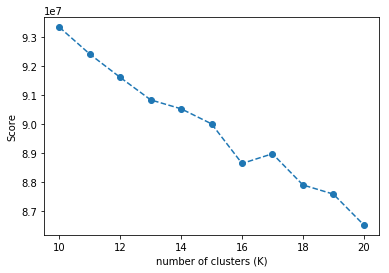

In [92]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(number_clusters,scores,marker='o',linestyle='--')
plt.xlabel('number of clusters (K)')
plt.ylabel('Score')
plt.show()

In [93]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=18)
model=kmeans.fit(data_PCA)
data_predict=model.predict(data_PCA)

### Discussion 3.1: Apply Clustering to General Population

Using sklearn's KMeans class to cluster the PCA data, the elbow graph shows that, as the score decreases, the number of clusters increases. I chose to use 18 clusters because it looks like the score significantly decreased starting 18. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [94]:
# Load in the customer demographics data.
customers =  pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [95]:
customers.shape

(191652, 85)

In [96]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [97]:
customers.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AGER_TYP,191652.0,0.344359,1.391672,-1.0,-1.0,0.0,2.0,3.0
ALTERSKATEGORIE_GROB,191652.0,3.060907,1.086254,1.0,3.0,3.0,4.0,9.0
ANREDE_KZ,191652.0,1.376432,0.484492,1.0,1.0,1.0,2.0,2.0
CJT_GESAMTTYP,188439.0,3.677928,1.813975,1.0,2.0,4.0,6.0,6.0
FINANZ_MINIMALIST,191652.0,3.963773,1.036230,1.0,3.0,4.0,5.0,5.0
FINANZ_SPARER,191652.0,2.057051,1.319422,1.0,1.0,1.0,4.0,5.0
FINANZ_VORSORGER,191652.0,4.183317,0.995365,1.0,3.0,5.0,5.0,5.0
FINANZ_ANLEGER,191652.0,2.439808,1.697932,1.0,1.0,2.0,5.0,5.0
FINANZ_UNAUFFAELLIGER,191652.0,2.646176,1.586506,1.0,1.0,2.0,5.0,5.0
FINANZ_HAUSBAUER,191652.0,2.781176,1.147353,1.0,2.0,3.0,3.0,5.0


In [98]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [99]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the customer demographics data.
df_cleancustomer = clean_data(customers, feat_infobk2) 

(191652, 85)
(191652, 77)
           attribute information_level         type missing_or_unknown
2          ANREDE_KZ            person  categorical             [-1,0]
3      CJT_GESAMTTYP            person  categorical                [0]
10         FINANZTYP            person  categorical               [-1]
12   GFK_URLAUBERTYP            person  categorical                 []
13  GREEN_AVANTGARDE            person  categorical                 []
17   LP_FAMILIE_FEIN            person  categorical                [0]
18   LP_FAMILIE_GROB            person  categorical                [0]
19    LP_STATUS_FEIN            person  categorical                [0]
20    LP_STATUS_GROB            person  categorical                [0]
21  NATIONALITAET_KZ            person  categorical             [-1,0]
38       SHOPPER_TYP            person  categorical               [-1]
39           SOHO_KZ            person  categorical               [-1]
41          VERS_TYP            person  categorical

In [100]:
df_cleancustomer.shape

(141725, 189)

In [101]:
set(test_cleanfunction)-set(df_cleancustomer.columns)

{'GEBAEUDETYP_5.0', 'KKK', 'REGIOTYP'}

In [102]:
df_cleancustomer["GEBAEUDETYP_5.0"]=0

In [103]:
df_cleancustomer["KKK"]=0

In [104]:
df_cleancustomer["REGIOTYP"]=0

In [105]:
df_cleancustomer.shape

(141725, 192)

In [106]:
df_cleancustomer.isnull().sum().sum()

0

In [107]:
df_cleancustomer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141725 entries, 0 to 191651
Columns: 192 entries, ALTERSKATEGORIE_GROB to REGIOTYP
dtypes: float64(37), int64(28), uint8(127)
memory usage: 88.5 MB


In [108]:
#feature transformation
scaler=StandardScaler()
customers_scaled=scaler.fit_transform(df_cleancustomer)
customers_scaled=pd.DataFrame(customers_scaled,columns=df_cleancustomer.columns.tolist())

In [109]:
customers_scaled

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE,GEBAEUDETYP_5.0,KKK,REGIOTYP
0,0.701602,0.702950,0.723187,-0.517025,0.516280,-0.600728,0.136954,-0.553065,1.006989,-1.256240,...,-0.083744,-0.118329,-0.103705,-0.655034,-0.988599,-1.132334,-0.285344,0.0,0.0,0.0
1,0.701602,-1.422577,0.723187,-0.517025,0.516280,-0.600728,2.180637,0.965870,1.006989,0.048555,...,-0.083744,-0.118329,-0.103705,-0.655034,-0.988599,0.290475,0.461490,0.0,0.0,0.0
2,0.701602,0.702950,0.723187,-0.517025,0.516280,0.396720,-0.884887,-0.553065,-0.993060,0.048555,...,-0.083744,-0.118329,-0.103705,-1.399516,1.011532,-0.420929,0.461490,0.0,0.0,0.0
3,-0.668378,0.702950,-1.241329,-0.517025,-0.665403,2.391617,3.202478,-0.553065,-0.993060,1.353350,...,-0.083744,-0.118329,-0.103705,0.833930,1.011532,1.001879,-1.779012,0.0,0.0,0.0
4,-0.668378,0.702950,0.723187,-0.517025,0.516280,-0.600728,0.136954,0.206403,1.006989,1.353350,...,-0.083744,-0.118329,-0.103705,-0.655034,-0.988599,0.290475,0.461490,0.0,0.0,0.0
5,0.701602,0.702950,0.723187,-0.517025,0.516280,-0.600728,-0.884887,-0.553065,1.006989,0.048555,...,-0.083744,-0.118329,-0.103705,-0.655034,-0.988599,-0.420929,-0.285344,0.0,0.0,0.0
6,0.701602,0.702950,0.723187,-0.517025,0.516280,-0.600728,0.136954,-0.553065,1.006989,-1.256240,...,-0.083744,-0.118329,-0.103705,-0.655034,-0.988599,-1.132334,1.208325,0.0,0.0,0.0
7,0.701602,-1.422577,-2.223587,0.681440,0.516280,-0.600728,-0.884887,1.725337,-0.993060,0.048555,...,-0.083744,-0.118329,9.642722,-1.399516,1.011532,1.713283,1.208325,0.0,0.0,0.0
8,-0.668378,0.702950,0.723187,0.681440,-0.665403,-0.600728,1.158796,-1.312532,1.006989,1.353350,...,-0.083744,-0.118329,-0.103705,0.833930,-0.988599,-1.132334,1.208325,0.0,0.0,0.0
9,0.701602,0.702950,0.723187,-0.517025,0.516280,-0.600728,1.158796,-0.553065,1.006989,-1.256240,...,-0.083744,-0.118329,-0.103705,-0.655034,-0.988599,-1.132334,0.461490,0.0,0.0,0.0


In [110]:
customers_pca=pca_80.transform(customers_scaled)

In [111]:
customers_pca

array([[-1.04422018,  0.33253038,  3.10796653, ...,  0.3521767 ,
        -0.30354325,  0.14844827],
       [-0.95832613,  2.19062632, -2.79414905, ...,  0.51751862,
        -0.24552236,  1.41923382],
       [-0.14888547, -0.12857127,  1.62322472, ..., -1.23483645,
         1.0769489 , -0.2012868 ],
       ..., 
       [-1.47211746,  1.22720224,  0.78972834, ..., -0.02811642,
         0.97131829,  0.61606431],
       [ 0.5396379 ,  1.7038725 , -2.87178726, ..., -0.62386276,
        -0.37919254,  0.67836687],
       [ 1.09642041, -3.19935378,  2.09174071, ..., -1.60318104,
         1.15635322,  0.25343451]])

In [112]:
#customers_scaled
predict_customers=model.predict(customers_pca)

In [113]:
predict_customers

array([ 4, 12,  4, ...,  1, 12,  2], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [114]:
data_predict.shape

(798061,)

In [115]:
predict_customers.shape

(141725,)

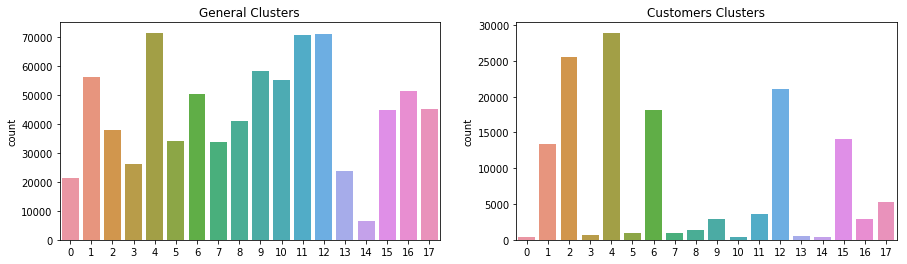

In [116]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
ax1.set_title('General Clusters')
sns.countplot(data_predict,ax=ax1)

ax2.set_title('Customers Clusters')
sns.countplot(predict_customers,ax=ax2)

plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f729e165eb8>]], dtype=object)

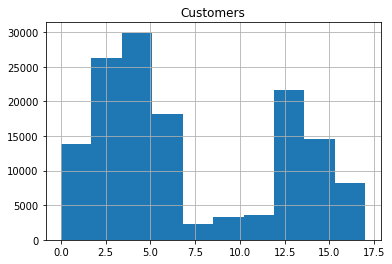

In [117]:
customergraph=pd.DataFrame(predict_customers, columns=['Customers'])

customergraph.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f729e114240>]], dtype=object)

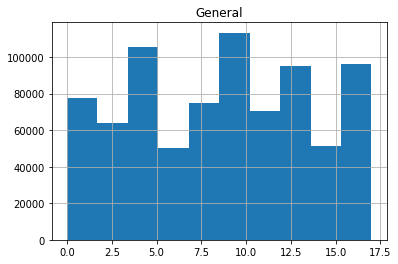

In [118]:
generalgraph=pd.DataFrame(data_predict, columns=['General'])

generalgraph.hist()

In [119]:
#Using top and bottom values from 3 principal components above
positive_correlation=["LP_STATUS_GROB_1.0","HH_EINKOMMEN_SCORE","WEALTH","PLZ8_ANTG3","ALTERSKATEGORIE_GROB","FINANZ_VORSORGER","ZABEOTYP_3.0","SEMIO_ERL",
"ANREDE_KZ","SEMIO_VERT","SEMIO_FAM","SEMIO_SOZ"]
negative_correlation=["FINANZ_MINIMALIST","MOBI_REGIO","PLZ8_ANTG1","KBA05_GBZ","DECADE","FINANZ_SPARER","FINANZ_UNAUFFAELLIGER","SEMIO_REL",
             "SEMIO_KAEM","SEMIO_DOM","SEMIO_KRIT","SEMIO_ERL"]

In [125]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#from the graph shown above, cluster 4 is over represented
centroid_1 = scaler.inverse_transform(pca_80.inverse_transform(model.cluster_centers_[4]))

In [126]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#from the graph shown above cluster 14 is under represented
centroid_2 = scaler.inverse_transform(pca_80.inverse_transform(model.cluster_centers_[14]))

In [127]:
centroids=pd.DataFrame({"feature":df_cleancustomer.columns,"centroid_1":centroid_1,"centroid_2":centroid_2})

In [128]:
centroids[centroids["feature"].isin(positive_correlation)]

,feature,centroid_1,centroid_2
0,ALTERSKATEGORIE_GROB,3.786373,4.061438
1,ANREDE_KZ,1.099410,0.519136
4,FINANZ_VORSORGER,5.054474,5.225401
11,SEMIO_SOZ,5.217659,3.958078
12,SEMIO_FAM,4.854736,3.124870
15,SEMIO_VERT,6.459382,4.751114
17,SEMIO_ERL,4.477710,6.272516
29,HH_EINKOMMEN_SCORE,4.450856,4.609821
51,PLZ8_ANTG3,0.795375,0.965243
108,LP_STATUS_GROB_1.0,0.010297,0.023568


In [124]:
centroids[centroids["feature"].isin(negative_correlation)]

,feature,centroid_1,centroid_2
2,FINANZ_MINIMALIST,5.442347,3.314797
3,FINANZ_SPARER,0.562512,2.438115
6,FINANZ_UNAUFFAELLIGER,1.291179,2.744699
13,SEMIO_REL,2.102422,4.961229
17,SEMIO_ERL,5.717594,2.619310
20,SEMIO_KRIT,3.885151,2.120130
21,SEMIO_DOM,4.043776,2.476864
22,SEMIO_KAEM,3.608346,1.849134
41,KBA05_GBZ,4.544759,2.759368
46,MOBI_REGIO,2.993641,4.053803


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Although the steps taken above is quite comprehensive, there are additional steps that I could include to make better prediction and analysis. For example, i could include transformation of all mixed-type features. For the interest of finishing this project, I just focused on two features that are required, such as "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015". I think if other mixed-type features were re-engineered, the result of analysis could be different. Additionally, I could explore different strategy in cleaning assessing and cleaning the data. 

The comparison graphs clearly shows that customers in cluster 4 is over represented and cluster 16 is under represented. While general population, are similar in cluster 4, general population highly represented in cluster 16. Based on the features from prinicipal components with positve correlation, the following features scored higher: SEMIO_VERT (Personality topology: Dreamful), SEMIO_SOZ (Personality topology: Socially minded) and SEMIO_FAM(Personality topology:  Family minded), ALTERSKATEGORIE_GROB (Estimated Age), ANREDE_KZ (Gender), and FINANZ_VORSORGER (Financial topology). The scores shows that the profile of customers are leaning towards gender, personality, and financial status.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

References used:
1. https://scikit-learn.org/stable/modules/classes.html

2. https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

3. https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py

4. https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.subplots.html

5. https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
